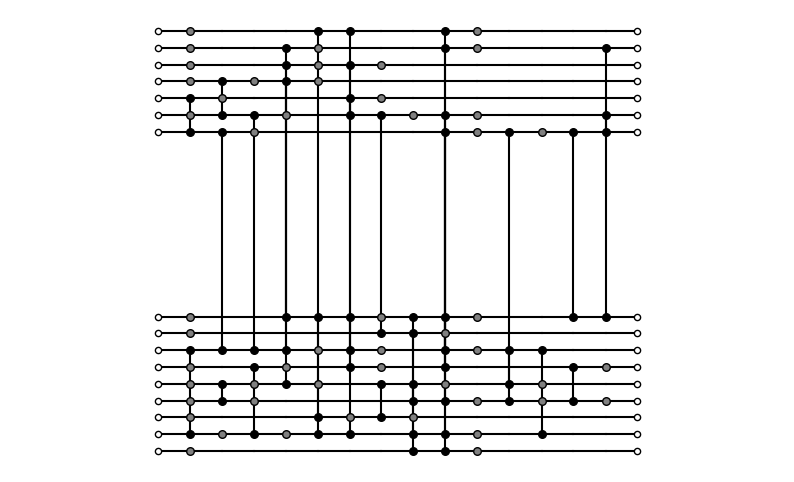

In [155]:
from circuits.cp_fraction import cp_fraction
from src.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from src.FM_methods import set_initial_partitions
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from circuits.QAOA import QAOA_random
import numpy as np

num_qubits = 16
num_partitions = 2
qpu_size = int(num_qubits / num_partitions) + 1
qpu_info = [qpu_size] * num_partitions

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.3)

# circuit = QFT(num_qubits, do_swaps=False)

# # circuit = QuantumVolume(num_qubits, depth=num_qubits)

# circuit = QAOA_random(num_qubits, prob = 0.5, reps = 1)

# ansatz = EfficientSU2(num_qubits, entanglement='full', reps=1)

# param_values = np.random.rand(len(ansatz.parameters))
# param_dict = dict(zip(ansatz.parameters, param_values))
# circuit = ansatz.assign_parameters(param_dict)


circuit = transpile(circuit, basis_gates = ['cp', 'u'])

depth = circuit.depth()

graph = QuantumCircuitHyperGraph(num_qubits=num_qubits, depth=depth)
graph.map_circuit_to_hypergraph(circuit, group_gates = False, anti_diag = False)
assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from src.tikz_drawing import *
from src.mpl_drawing import *

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    sum(qpu_info),
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)


In [156]:
def extract_partitioned_circuit(hgraph,
                                partition_assignment,
                                qpu_info,
                                comm_qubits_per_pair=1):
    """
    Build a Qiskit circuit from a hypergraph + partition assignment,
    inserting teleportation instructions (state or gate teleportation)
    whenever an edge is cut.

    :param hgraph: QuantumCircuitHyperGraph containing nodes and hyperedges.
    :param partition_assignment: dict {(q, t) -> partition_index}
    :param num_data_qubits_per_partition: list or dict specifying how many
                                          data-qubit 'slots' each partition has.
    :param num_partitions: int, total number of partitions
    :param comm_qubits_per_pair: int, how many communication qubits to allocate
                                 for each pair of partitions
    :return: A new QuantumCircuit implementing the assigned partitioning with
             added teleportation protocols.
    """

    # ---------------------------------------------------
    # 1) Create data-qubit quantum registers for partitions
    # ---------------------------------------------------
    num_partitions = len(qpu_info)
    num_data_qubits_per_partition = [qpu_info[i] for i in range(num_partitions)]
    partition_qregs = []

    for i in range(num_partitions):
        size_i = num_data_qubits_per_partition[i]
        qr = QuantumRegister(size_i, name=f"part{i}_data")
        partition_qregs.append(qr)

    # ---------------------------------------------------
    # 2) Create communication-qubit registers
    #    We'll create one register for each partition pair, sized by comm_qubits_per_pair.
    #    For convenience, store them in a dict keyed by (min_part, max_part).
    # ---------------------------------------------------
    comm_qregs = {}
    for p1 in range(num_partitions):
        for p2 in range(p1+1, num_partitions):
            comm_qregs[(p1, p2)] = QuantumRegister(comm_qubits_per_pair,
                                                  name=f"comm_{p1}_{p2}")

    # ---------------------------------------------------
    # 3) Create a classical register.
    #    We guess the number of classical bits. A rough rule:
    #    - 2 bits per qubit teleportation
    #    - 2 bits per two-qubit gate teleportation
    #    We'll over-allocate for simplicity or carefully compute.
    # ---------------------------------------------------

    classical_bits_needed = 2 * (len(hgraph.nodes) + len(hgraph.hyperedges))
    creg = ClassicalRegister(classical_bits_needed, name="c")
    
    # Build the final circuit with all qubit regs + 1 big classical reg.
    qc = QuantumCircuit(*partition_qregs, *comm_qregs.values(), creg, name="PartitionedCircuit")
    
    # We will keep an index into classical_bits_needed to know where to measure next
    cbit_index = 0

    # ---------------------------------------------------
    # 4) A helper mapping: which "physical qubit" does logical (q, t) correspond to?
    #    We'll store (partition_index, data_qubit_index_in_that_partition).
    #
    #    Because a qubit can move from partition A to B after teleportation,
    #    we only finalize (q,t)->(partition,slot) after we see we are in time t.
    # ---------------------------------------------------
    location_map = {}

    # We'll also need to track how many data-qubit 'slots' in each partition
    # are in use at a given time.  In a more advanced system you might reuse
    # the same "slot" once the previous occupant has moved away.
    # For simplicity, we keep a running usage for each partition.
    usage_counters = [0]*num_partitions

    # A small helper function that assigns a data qubit slot in a partition:
    def allocate_data_qubit_slot(part):
        slot = usage_counters[part]
        usage_counters[part] += 1
        if slot >= num_data_qubits_per_partition[part]:
            raise ValueError(f"Partition {part} is out of data-qubit slots!")
        return slot

    # ---------------------------------------------------
    # 5) Pre-populate location_map for time=0
    #    For each node (q,0), see partition_assignment -> allocate a slot.
    # ---------------------------------------------------
    max_time = hgraph.depth  # or you can infer from the largest 't' in hgraph
    for q in range(hgraph.num_qubits):
        print(f"Qubit {q} at t=0 is in partition {partition_assignment[(0,q)]}")
        # The node (q,0) should exist if the circuit has that qubit at t=0
        part0 = partition_assignment[0][q]
        slot0 = allocate_data_qubit_slot(part0)
        location_map[(q, 0)] = (part0, slot0)
    
    # ---------------------------------------------------
    # 6) Step through times t in [0, max_time-1], building the circuit
    #    - Insert gates that occur at time t
    #    - Handle cuts in the time-neighbor edges => state teleportation
    # ---------------------------------------------------
    
    # A small helper to produce a Bell pair on comm qubits (we do a simple circuit).
    def generate_epr_between(p1, p2, comm_idx=0):
        """
        Generate |Phi^+> on the comm_idx'th qubit of comm_qregs[(p1,p2)].
        Return the tuple of Qiskit qubits for referencing.
        """
        if p1 > p2:
            p1, p2 = p2, p1  # reorder so that (p1,p2) is always the key
        qr_comm = comm_qregs[(p1, p2)]

        qA = qc.qubits.index(qr_comm[comm_idx])  # integer index in qc
        # For convenience we can just do the operations by name on the raw Qubit objects:
        qc.h(qr_comm[comm_idx])
        qc.cx(qr_comm[comm_idx], qr_comm[comm_idx+1 % qr_comm.size])
        
        return (qr_comm[comm_idx], qr_comm[(comm_idx+1) % qr_comm.size])
    
    # A helper for a basic state teleportation from qubit A in partition pA
    # to partition pB using a given comm qubit. We'll return the new
    # data-qubit slot in pB that ends up holding the teleported state.
    def state_teleport(qubitA, partitionA, partitionB, cbit_start):
        """
        Teleport the state of 'qubitA' in partitionA to a new data-qubit slot in partitionB.
        Use one EPR pair on comm_qregs[(pA, pB)].
        cbit_start is the index for the classical register bits to store measurement outcomes.
        """
        # 1) Allocate data qubit slot in partitionB
        slotB = allocate_data_qubit_slot(partitionB)
        # 2) Generate EPR pair
        #    We'll just pick comm_idx=0 for demonstration.  In a more advanced system, you'd
        #    manage the usage of multiple comm qubits, or "reset" them after use, etc.
        (qEPR0, qEPR1) = generate_epr_between(partitionA, partitionB, comm_idx=0)

        # Identify the actual Qubit object references
        data_qA = partition_qregs[partitionA][qubitA]    # Qubit object in qc
        data_qB = partition_qregs[partitionB][slotB]
        
        # 3) Teleportation circuit:
        #    measure Bell on (data_qA, qEPR0)
        qc.cx(data_qA, qEPR0)
        qc.h(data_qA)
        qc.measure(data_qA, creg[cbit_start])     # first classical bit
        qc.measure(qEPR0, creg[cbit_start+1])     # second classical bit
        # 4) Conditioned corrections on data_qB (the other half of EPR)
        qc.x(data_qB).c_if(creg, 1 << (cbit_start+1))  # if second measurement bit is 1
        qc.z(data_qB).c_if(creg, 1 << (cbit_start))    # if first measurement bit is 1

        return slotB

    # Similarly, you'd define a "gate_teleportation" helper for two-qubit gates
    # across partitions.  The logic is more involved (especially if you're doing
    # a full universal 2-qubit gate teleport).  For a simple 'cx', there's a known
    # specialized protocol.  In practice, you might just do "teleport one qubit
    # next to the other and do local CNOT", or implement a proper entanglement
    # swapping protocol, etc.
    
    # We'll do a simple pass: at each t,
    # - for each gate/hyperedge of type=gate at time t,
    #   if all in same partition => local gate
    #   else => gate_teleportation(...) or move qubits so they're together
    # - then check the time edges (q,t)->(q,t+1) if partition changed => state teleport
    # 
    # In your code, you'd parse the hyperedges carefully.  We'll just show the structure:

    for t_step in range(max_time):
        # 6a) Apply any gates that exist at time t
        # We need to look up hyperedges that occur at time t.  If your map_circuit_to_hypergraph
        # has stored gate hyperedges with attribute "time" or "layer", you can filter them here.
        # 
        # We'll do a pseudo-iteration over edges:
        print(f"Time step {t_step}")
        for q in range(hgraph.num_qubits):    
            node = (q, t_step)
            type_of_node = hgraph.get_node_attribute(node, 'type')
            if type_of_node == 'single-qubit':
                params = hgraph.get_node_attribute(node, 'params')
                # Apply the single-qubit gate
                p = partition_assignment[(t_step, q)]
                slot = location_map[(q, t_step)]
                data = partition_qregs[p][slot[1]]
                qc.u(params[0], params[1], params[2], data)
                
            for edge_id in hgraph.node2hyperedges[node]:
                # Suppose we stored `time = t` in the hyperedge_attrs...
                edge_data = hgraph.hyperedges[edge_id]
                # print(f"Processing edge {edge_id} at time {t}")
                # print(f'Edge data: {edge_data}')
                gate_time = min(edge_id[0][1], edge_id[1][1])  # min time of the two nodes
                # check partitions of the involved data qubits
                root_set = edge_data['root_set']
                recv_set = edge_data['receiver_set']
                all_nodes = root_set.union(recv_set)
                print(edge_id)
                if edge_id[0][1] == edge_id[1][1]:
                    # Gate
                    print(f"Nodes in edge: {all_nodes}")
                    partitions_of_nodes = set()
                    node_to_phys = {}
                    for node_qt in all_nodes:
                        (qnode, tnode) = node_qt
                        p = partition_assignment[tnode][qnode]
                        slot = location_map.get(node_qt, None)

                        if slot is None:
                            # Possibly we've never assigned this node explicitly 
                            # because it's a "group" sub-node. You may need a more robust method...
                            slot = (p, allocate_data_qubit_slot(p))
                            location_map[node_qt] = slot
                        
                        node_to_phys[node_qt] = slot
                        partitions_of_nodes.add(p)

                    # If all qubits are in the same partition => local gate
                    if len(partitions_of_nodes) == 1:
                        p_local = partitions_of_nodes.pop()
                        # retrieve gate info
                        gname = hgraph.get_hyperedge_attribute(edge_id, 'name')
                        # you would also retrieve `params` if needed
                        # then apply the local gate on the correct qubits
                        if len(all_nodes) == 2:
                            # e.g. a two-qubit gate
                            node_list = list(all_nodes)
                            (qA, tA), (qB, tB) = node_list[0], node_list[1]
                            slotA = location_map[(qA, tA)]
                            slotB = location_map[(qB, tB)]
                            dataA = partition_qregs[p_local][slotA[1]]
                            dataB = partition_qregs[p_local][slotB[1]]
                            print(f'Node list:', node_list)
                            print(f'Qubit slots:', slotA, slotB)
                            print(f'Qubit data:', dataA, dataB)
                            
                            if gname == 'cp':
                                params = hgraph.get_hyperedge_attribute(edge_id, 'params')
                                qc.cp(params[0], dataA, dataB)
                            elif gname == 'cz':
                                qc.cz(dataA, dataB)
                            # etc. for other gates...
                        else:
                            # single-qubit or multi-qubit group
                            pass
                    else:
                        # Gate is cut across multiple partitions => gate teleportation
                        # For demonstration, let's do the naive approach:
                        #   "teleport qubit(s) so they're in the same partition and do local gate"
                        # In a real pipeline you might do a more efficient "distributed gate" protocol.
                        
                        # Identify some "primary" partition, say the first in the set
                        # Teleport the other qubits to that partition, then do local gate.
                        parted_list = list(partitions_of_nodes)
                        p0 = parted_list[0]
                        # for each other partition pX in parted_list[1:], teleport qubits in pX to p0
                        for pX in parted_list[1:]:
                            # find which qubits are at pX
                            for node_qt in all_nodes:
                                if partition_assignment[node_qt[1]][node_qt[0]] == pX:
                                    # state teleport from pX => p0
                                    old_slot = location_map[node_qt]
                                    EPR0, EPR1 = generate_epr_between(
                                        p1=pX,
                                        p2=p0
                                    )
                                    # update location_map
                                    location_map[node_qt] = (p0, new_slot)
                                    cbit_index += 2  # used up 2 classical bits
                        # now all relevant qubits for the gate are in p0, apply the gate
                        # same local gate logic as above
                        gname = hgraph.get_hyperedge_attribute(edge_id,'name')
                            # etc...
                else:
                    if edge_id[0][0] == edge_id[1][0]:
                        p_t = partition_assignment[(t_step, q)]
                        p_t1 = partition_assignment[(t_step+1, q)]
                        print(f"Time edge: {edge_id} from {p_t} to {p_t1}")
                        if p_t != p_t1:
                            # We have a cut on the time neighbor => teleport qubit q from p_t to p_t1
                            old_slot = location_map[(q, t_step)]
                            # Teleport from old_slot to new partition
                            new_slot = state_teleport(
                                qubitA=old_slot[1],
                                partitionA=p_t,
                                partitionB=p_t1,
                                cbit_start=cbit_index
                            )
                            cbit_index += 2
                            # Update location map
                            location_map[(q, t_step+1)] = (p_t1, new_slot)
                        else:
                            # No teleportation needed. Just assign same physical slot
                            location_map[(q, t_step+1)] = location_map[(q, t_step)]

        # # Done building the circuit
        return qc




In [157]:
print(assignment)

circuit = extract_partitioned_circuit(graph, assignment, qpu_info, comm_qubits_per_pair=4)

[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]]
Qubit 0 at t=0 is in partition 0
Qubit 1 at t=0 is in partition 0
Qubit 2 at t=0 is in partition 0
Qubit 3 at t=0 is in partition 0
Qubit 4 at t=0 is in partition 0
Qubit 5 at t=0 is in partition 0
Qubit 6 at t=0 is in partition 0
Qubit 7 at t=0 is in partition 0
Qubit 8 at t=0 is in partition 0
Qubit 9 at t=0 is in partition 1
Qubit 10 at t=0 is in partition 1
Qubit 11 at t=0 is in partition 1
Qubit 12 at t=0 is in partition 1
Qubit 13 at t=0 is in partition 1
Qubit 14 at t=0 is in partition 1
Qubit 15 

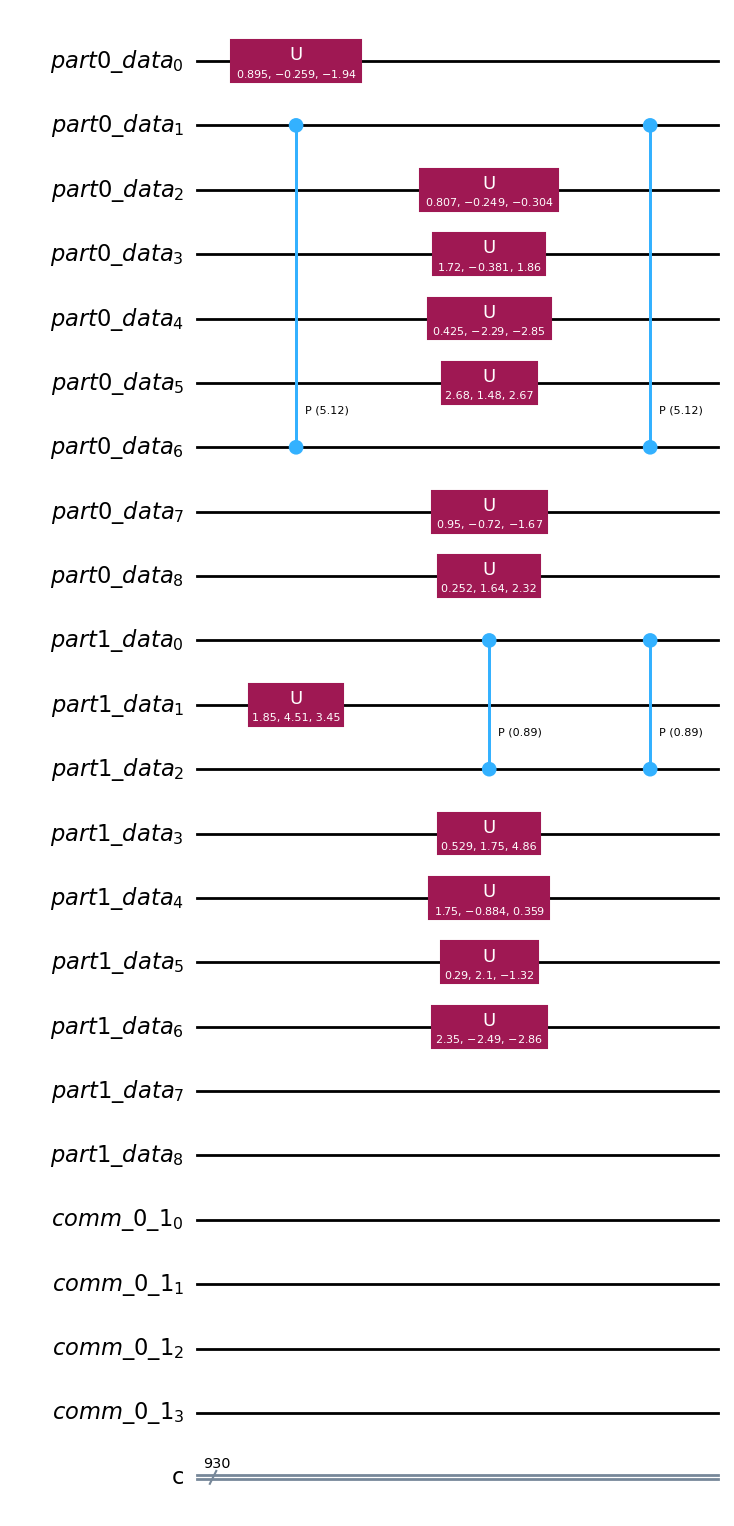

In [158]:
circuit.draw('mpl')